In this last notebook we are going to use the confusion matrix. We are going to play with the y_proba function. This functions give us a probability that the predictions fall within a certain class. Generally we work with just with accuracy 
so we do not see these probabilities, but when we have errors that are more costly than others we can find tune this!

This is a short notebook, but it has a tricky part. This is because we use train_test_split and cross_val_score at the same time. 
This was not a mistake!
When we use cross validation we are looking for the scores and y_proba values for the best model we got so far.
We want to work with those models to see how we can **change** the **y_proba function threshold** to change the **confussion matrix**. Notice that we train the model with the new training set (this is a subset) that we got here.

So we get those values (**scores and y_proba**) and we **need to change the threshold in y_proba** and test how we are doing in a data that we haven't see it yet. And because we need to test how the model + differents threshold is behaving in unseen data we do a split in training and testing data at the beginning to test this points later.



In [4]:
#pip install scikit-plot

In [5]:
# import 
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# This Libraries were use in the other example because we needed to predict a numerical value
# now we are predicting a category

# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_absolute_error

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

# New libraries that we haven't use yet!
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# These functions are going to be use in the next notebook
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

import scikitplot as skplt


# Let us have a clearer code
from utils import cleaning_data

In [6]:
# This data you can find here: https://www.kaggle.com/competitions/spaceship-titanic/data
X_full = pd.read_csv('train.csv', index_col='PassengerId')

# This is the real test, but we are going to use a test created by us to use easily ROC-AUC

# X_test_full = pd.read_csv('test.csv', index_col='PassengerId')

# Transported is the target, if there is no target eliminate row associated with it
column_to_predict = "Transported"
X_full.dropna(axis=0, subset=[column_to_predict], inplace=True)
y = X_full[column_to_predict]
X = X_full.copy()
X.drop([column_to_predict], axis=1, inplace=True)

all_columns = X.columns


X, X_test, y, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                random_state=0)  

In [7]:
X = cleaning_data(X)
new_columns = X.columns
# columns deleted given the criterion from the function cleaning_data
deleted_columns = set(all_columns) - set(new_columns)
deleted_columns

{'Cabin', 'Name'}

In [8]:
def fix_model(X,y,X_test=False,
             cv=3,n_jobs=-1,scoring='accuracy',
             max_depth=10,n_estimators=344,n_neighbors=5,thr=0.5 ):
    # separating the data in training/validation
    # X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
    #                                                  random_state=0)        
    
    # We are gonna use a cross validation now
    
    """
    best model so far is: 
    {'model__max_depth': 10,
    'model__n_estimators': 344,
    'preprocessor__numerical_transformer__imputer__n_neighbors': 5}
    
    
    """

    X_train = X
    y_train = y
    
    numerical_col = [col for col in X_train.columns if str(X_train[col].dtypes)!='object' ]
    numerical_col_imputed = [col for col in numerical_col if X_train[col].isnull().any()==True]

    categorical_col = [col for col in X_train.columns if str(X_train[col].dtypes)=='object' ]
    categorical_col_imputed = [col for col in categorical_col if X_train[col].isnull().any()==True]
    # n_neighbors = an integer. KNNImputer 
    numerical_transformer = Pipeline(
    steps=[("scaler", StandardScaler()), ("imputer", KNNImputer(n_neighbors=n_neighbors))
          ]
    )

    categorical_transformer =  Pipeline(steps=[
        ('imputer', SimpleImputer(missing_values=pd.NA, strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer(transformers=
        [("numerical_transformer", numerical_transformer, numerical_col_imputed),
        ("categorical_transformer", categorical_transformer, categorical_col)],remainder='passthrough')

    # Define model
    model = RandomForestClassifier(max_depth=max_depth,n_estimators=n_estimators ,random_state=0,n_jobs=n_jobs)

    # Bundle preprocessing and modeling code in a pipeline
    pipe = Pipeline(steps=[('preprocessor', preprocessor),
                          ('model', model)
                         ])
    # this "just" give me the score
    scores =  cross_val_score(pipe, X, y,cv=cv,scoring=scoring)
    
    # this fit the pipeline to a specific model, giving an specific traning set (notice that the cross-val does not do that)
    pipe.fit(X_train,y_train)
    y_proba = None
    try:
        # X_test = False this will not run and it is ok
        y_proba = pipe.predict_proba(X_test)
    except:
        pass
    
    return scores, y_proba

In [9]:
# What we got so far is
scores, y_proba = fix_model(X,y,X_test=X_test, scoring='roc_auc' )

In [21]:
def plot_confusion_matrix(y_proba,y_test,thr=0.5):
    y_pred = (y_proba[:, 1] >= thr).astype(int)
    fpr, tpr, thresholds = roc_curve(y_test,y_pred)
    acurracy = accuracy_score(y_test, y_pred)
    return print(f"acurracy : {round(acurracy,3)*100}% "),skplt.metrics.plot_confusion_matrix(y_test, y_pred)

acurracy : 79.4% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

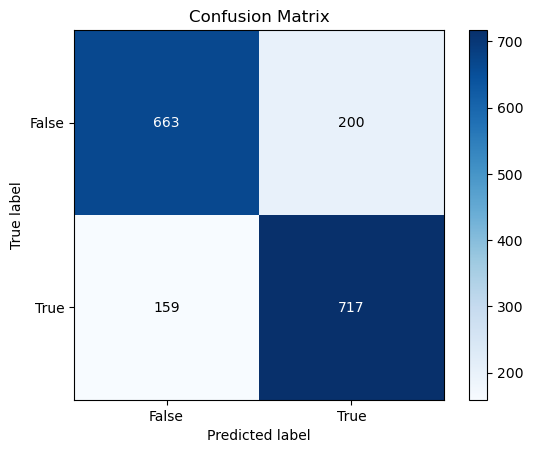

In [22]:
# Over 0.5 we have positive and below negative, a pretty normal way to do it!
plot_confusion_matrix(y_proba,y_test,thr=0.5)

acurracy : 78.9% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

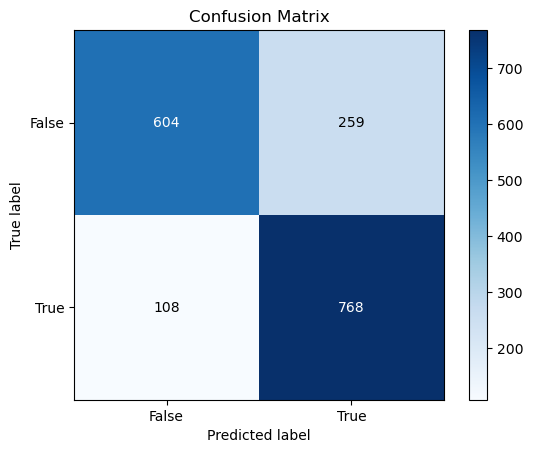

In [23]:
# Let us say that we want to increse the number of positive correcly classified (second column and second row)
plot_confusion_matrix(y_proba,y_test,thr=0.4)

acurracy : 77.10000000000001% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

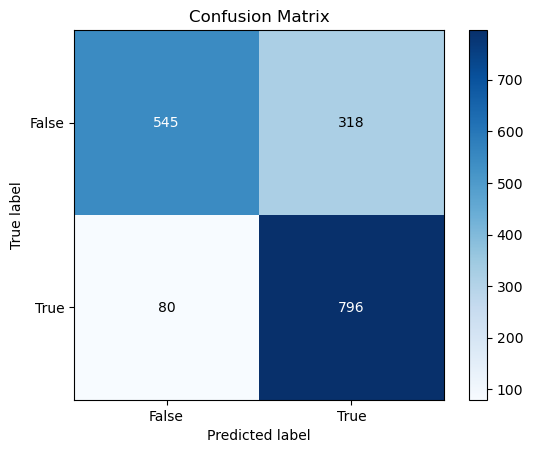

In [24]:
# Let us say that we want to increse the number of positive correcly classified (second column and second row)
plot_confusion_matrix(y_proba,y_test,thr=0.3)

acurracy : 70.3% 


(None,
 <Axes: title={'center': 'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>)

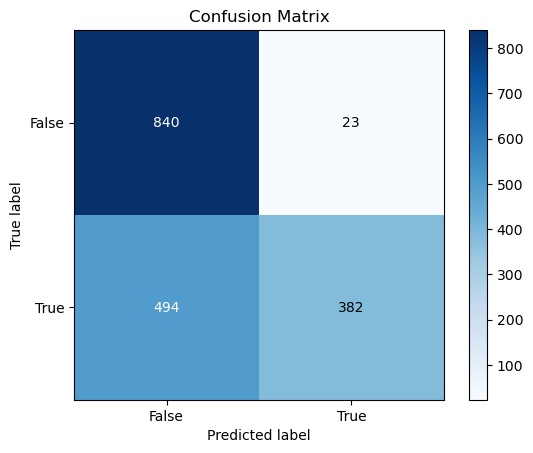

In [25]:
# Let us say that we want to increse the number of negative correcly classified (first column and first row)
plot_confusion_matrix(y_proba,y_test,thr=0.8)

Notice how playing around with y_proba and his threshold to predict possitive examples can change acurracy, the best result will be always with 0.5, but we can play with this others results in case one type of mistake is more expensive than others. 